# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">1-Packges and libraries</center>

In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/ub/Desktop/crypto-analysis-forcasting'

In [2]:
import itertools
import pandas as pd
import numpy as np
import math

import plotly.express as px
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json, model_from_json

from prophet import Prophet

from data import data_cleaning



# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">2-Data</center>

In [3]:
df_orginal,df,df_train,df_test=data_cleaning("btc",split_point=-447)


In [4]:
df_train.index=df_train.index.to_timestamp()
df_train.reset_index(inplace=True)
df_train.rename(columns={"price":"y","date":"ds"},inplace=True)


/tmp/ipykernel_71096/503395719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={"price":"y","date":"ds"},inplace=True)


# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">2-Setting hyperprameter tunning</center>

In [9]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
mape  = []  # Store the MAPEs for each params here



https://facebook.github.io/prophet/docs/diagnostics.html

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of yhat vs. y.

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [10]:

# Use cross validation to evaluate all parameters
for params in all_params:
    
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, initial='180 days', period='45 days', horizon = '90 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mape.append(df_p['mape'].values[0])


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mape


20:45:44 - cmdstanpy - INFO - Chain [1] done processing
20:45:44 - cmdstanpy - INFO - Chain [1] start processing
20:45:46 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale         rmse      mape
0                     0.001                     0.01  9450.335768  0.542605
1                     0.001                     0.10  9467.821723  0.573919
2                     0.001                     1.00  9499.251469  0.674731
3                     0.001                    10.00  9647.032762  1.016970
4                     0.010                     0.01  7970.395078  0.509429
5                     0.010                     0.10  7977.987749  0.547354
6                     0.010                     1.00  7996.589268  0.552146
7                     0.010                    10.00  8001.434545  0.550597
8                     0.100                     0.01  7604.414785  0.397181
9                     0.100                     0.10  7608.986571  0.453597
10                    0.100                     1.00  7615.435133  0.472636
11                    0.100                    10.00  7620.940288  0.478471
12          

# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">3-Retraining with best hyperparameters</center>

In [16]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [17]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


In [18]:
model = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=0.01)
model.fit(df_train)

20:48:15 - cmdstanpy - INFO - Chain [1] start processing
20:48:17 - cmdstanpy - INFO - Chain [1] done processing


# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">4- forcasting</center>

In [29]:
future = model.make_future_dataframe(periods=448)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3443,2022-10-09,76508.905902,-39897.256349,189091.899454
3444,2022-10-10,76667.141454,-38094.484734,186877.092222
3445,2022-10-11,76839.040250,-38179.293126,191645.208856
3446,2022-10-12,77013.656060,-39985.386350,188779.793795
3447,2022-10-13,77207.830917,-40721.158927,190601.380355


In [30]:
plot_plotly(model, forecast)

/tmp/ipykernel_34905/2201391353.py:2: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



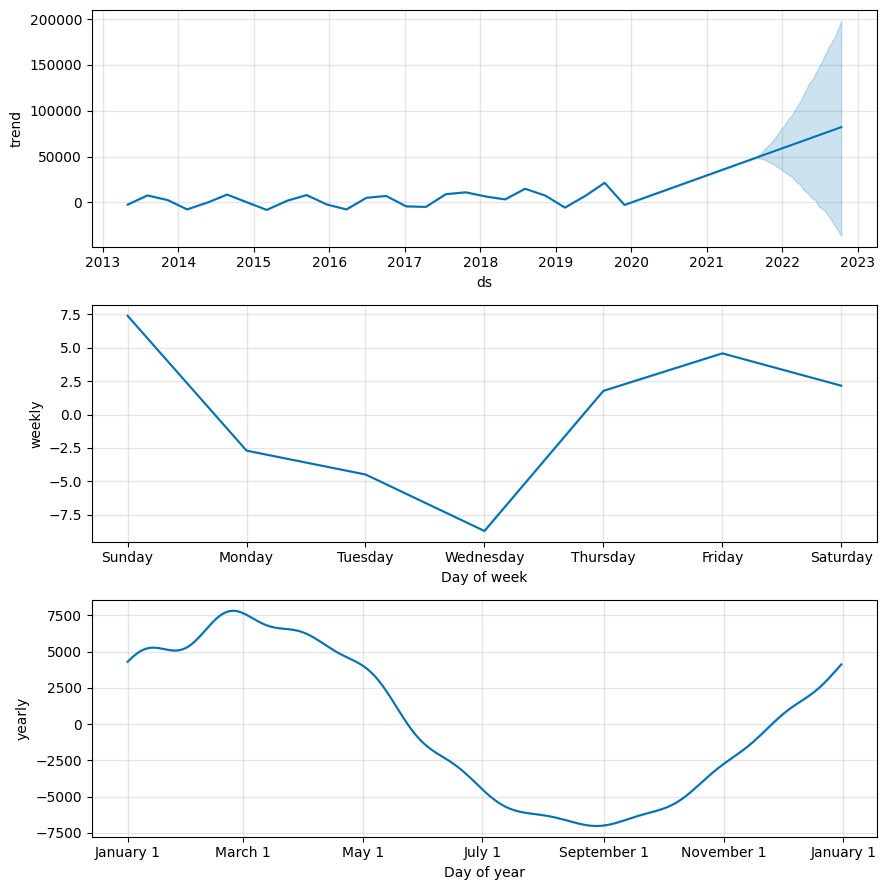

In [31]:
prophet_comp = model.plot_components(forecast)
prophet_comp.show()

In [32]:
with open('models/saved/prophet_serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))

In [33]:
predictions= pd.read_csv('predictions.csv')

In [41]:
predictions["prophet_price"] = forecast[forecast.ds>'2021-07-23']['yhat'].values

In [43]:
predictions.to_csv("predictions.csv")

In [5]:
with open('models/saved/prophet_serialized_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load mode
    
future = model.make_future_dataframe(periods=int(448))
forecast = model.predict(future)

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [6]:
prophet_fig= plot_plotly(model, forecast, figsize = (800, 600))


In [7]:
df_test.reset_index(inplace=True)

In [9]:
prophet_fig.add_trace(go.Scatter(
        name='Validation',
        x=df_test.date.astype(str),
        y=df_test['price'],
        marker=dict(color='red', size=4),
        mode='lines'
    ))
prophet_fig.show()